In [16]:
# USE THIS

In [2]:
import numpyro
import numpyro.distributions as dist
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax
from jax import random
from numpyro import infer
import jax.numpy as jnp
import arviz as az
import random as randomm
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import get_window
from math import floor as floor

#numpyro.set_host_device_count(2) # let's use 2 cores! jk i don't have 2 cores

In [9]:
# Generate 100 sine functions with different a,b,c parameters and random noise
def sine(a,b,c,x):
    return a * jax.numpy.sin((2*np.pi*b * x) + c)

dx = 0.001
x_data = np.arange(0,10,dx)
a_list = np.linspace(0.1,10,100)
b_list = np.linspace(0.1,3,100)
c_list = np.linspace(0,5,100)

# Choose one random sine function to work with
my_a = randomm.choice(a_list)
my_b = randomm.choice(b_list)
my_c = randomm.choice(c_list)

noise = np.random.normal(-my_a,my_a,len(x_data))
y_pure = sine(my_a, my_b, my_c, x_data)

y_data = y_pure + noise   #np.max(noise/2) keeps the signal centered on y=0
y_err = np.array([my_a] * len(x_data)) #[0] * len(y_data) #noise #np.random.rand(len(x_data)) 

<ErrorbarContainer object of 3 artists>

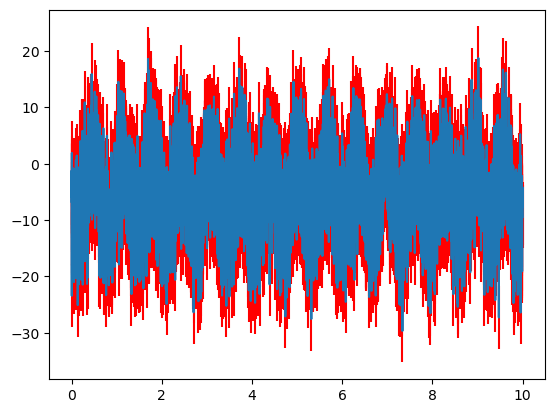

In [10]:
plt.errorbar(x_data, y_data, yerr=y_err, ecolor='red')

FFT freq:  1.5
b:  1.5353535353535352


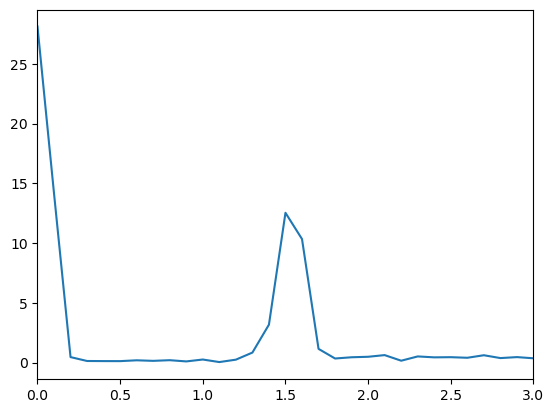

In [11]:
# Let's do a fourier transform to find b, the frequency.
# This will make the rest of the process faster since we'll only need to find 2 parameters (a & c) instead of 3.

def fft(y):
    N = len(y)
    fs = int(1.0 / dx)
    window = get_window('hann', y.size)
    win_data = y * window
    freq = np.fft.rfftfreq(len(win_data))*fs
    freq_domain = np.fft.rfft(win_data)/fs
    return freq, abs(freq_domain)

freqs, amps = fft(y_data)
plt.plot(freqs, amps)
plt.xlim(0,3)

check_amps = []
check_freqs = []
for i in range(0,len(amps)):
    if freqs[i] > 0.1:
        check_amps.append(amps[i])
        check_freqs.append(freqs[i])

for i in range(0,len(check_amps)):
    if check_amps[i] == np.max(check_amps):
        freq = check_freqs[i]
print('FFT freq: ',freq)
print('b: ',my_b)

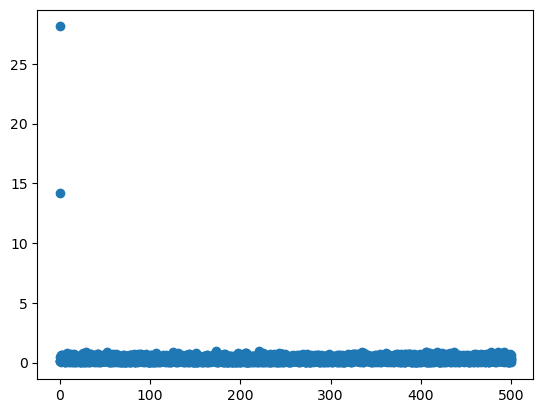

In [12]:
noise_freq, noise_amp = fft(noise)
plt.scatter(noise_freq,noise_amp)

In [13]:
halfnorm = dist.HalfNormal(scale=500).sample(random.PRNGKey(0), (100,))

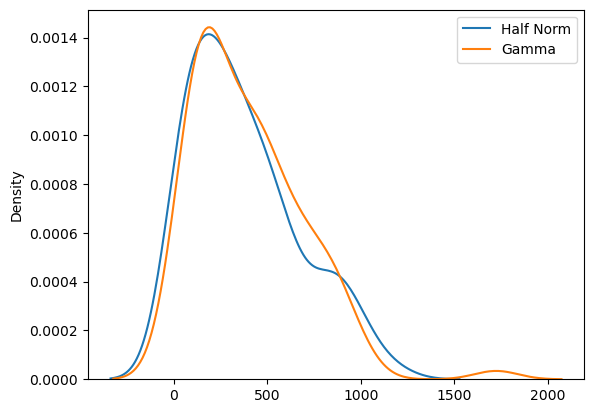

In [14]:
# alpha/beta = np.mean(halfnorm)
# alpha/beta^2 = np.var(halfnorm)

α = np.mean(halfnorm)**2/np.var(halfnorm)
β = np.mean(halfnorm)/np.var(halfnorm)

gamma = dist.Gamma(α, β).sample(random.PRNGKey(0), (100,))

sns.kdeplot(halfnorm, label='Half Norm')
sns.kdeplot(gamma, label='Gamma')
plt.legend();

This looks like a good Gamma distribution to replace the Half Normal distribution, so let's redo the linear model from the "Modeling Outliers w NumPyro" notebook:

In [15]:
def sine_model_w_outliers(x=None, y=None, σ_y=None):
    # First let's construct our foreground (i.e., linear) model
    a = numpyro.sample('a', dist.Uniform(0, 10))
    b = freq
    c = numpyro.sample('c', dist.Uniform(0, 5))
    μ_fg = sine(a,b,c,x)
    dist_fg = dist.Normal(μ_fg, σ_y)

    # Now lets define a model for the background (i.e., outliers)
    μ_bg = numpyro.sample('μ_bg', dist.Normal(loc=400, scale=500))
    σ_bg = numpyro.sample('σ_bg', dist.Gamma(α, β)) # replaced the Half Normal distribution here
    dist_bg = dist.Normal(μ_bg, jnp.sqrt(σ_bg**2 + σ_y**2))

    # We're going to assign each observation probabilistically to fg or bg using Categorical parameters
    P_fg = numpyro.sample('P_fg', dist.Uniform(0, 1)) # Prob an observation will be in the foreground

    # Define the foreground/background parameters, with equal probability between categories
    mixing_dist = dist.Categorical(probs=jnp.array([P_fg, 1 - P_fg]))
    mixture = dist.MixtureGeneral(mixing_dist, [dist_fg, dist_bg])

    # Likelihood
    with numpyro.plate("data", len(x)):
        y_ = numpyro.sample("obs", mixture, obs=y)

        # Until here, where we can track the membership probability of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "log_p_fg", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

In [16]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(sine_model_w_outliers)
num_samples = 1000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=100,
    num_samples=num_samples)
mcmc.run(rng_key_,
         x=x_data,
         y=y_data,
         σ_y=y_err)
mcmc.print_summary()

/tmp/ipykernel_47361/3187456997.py:7: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = infer.MCMC(
sample: 100%|██████████| 1100/1100 [00:07<00:00, 138.37it/s, 7 steps of size 4.08e-02. acc. prob=0.97] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      P_fg      0.28      0.01      0.28      0.26      0.31    696.50      1.01
         a      5.96      0.34      5.95      5.42      6.52    719.49      1.00
         c      4.36      0.04      4.36      4.29      4.43    563.45      1.00
      μ_bg     -7.50      0.15     -7.50     -7.72     -7.25    675.44      1.01
      σ_bg      2.18      0.19      2.19      1.90      2.52    916.54      1.01

Number of divergences: 0


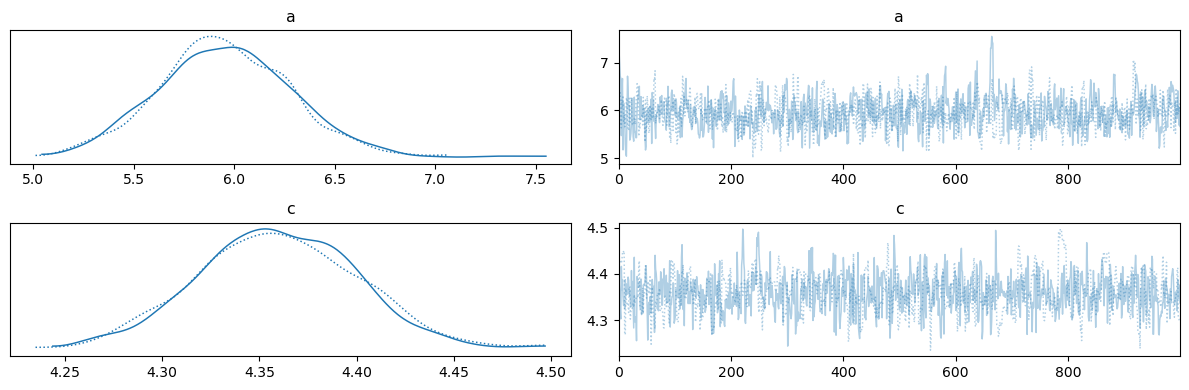

In [17]:
az.plot_trace(mcmc, var_names=['a', 'c']);
plt.tight_layout();

Let's check that the MCMC produced good m and b values:

a:  5.71563 | c:  4.3492165
a:  5.8654127 | c:  4.330063
a:  6.2417383 | c:  4.4141064
a:  6.2032723 | c:  4.3670387
a:  5.398454 | c:  4.386676
Actual a:  5.6 | Actual c:  3.3333333333333335


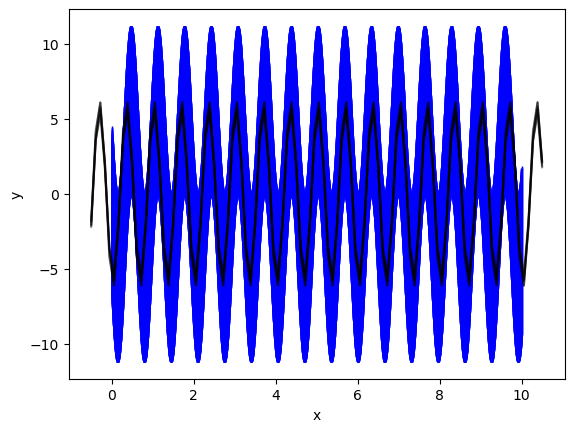

In [18]:
samples = mcmc.get_samples()

plt.errorbar(x_data, y_pure, y_err, fmt=",b", ms=0, capsize=0, lw=1)
plt.xlabel('x')
plt.ylabel('y')

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100)

for i in random.choice(rng_key, num_samples, (5,)):
    mu = samples['a'][i] * np.sin(2*np.pi*freq*x + samples['c'][i])
    plt.plot(x, mu, color='k', alpha=0.5);
    print('a: ',samples['a'][i],'| c: ',samples['c'][i])

print('Actual a: ',my_a,'| Actual c: ',my_c)

# 1:

In [24]:
def sine_model(x=None, y=None):
    # priors
    a = numpyro.sample('a', dist.Uniform(0.1, 10))
    b = freq
    c = numpyro.sample('c', dist.Uniform(0, 5))
    σ = numpyro.sample('σ_mg', dist.HalfNormal(scale=5))

    μ = sine(a,b,c,x)
    
    # likelihood
    obs = numpyro.sample("obs", dist.Normal(μ, σ), obs=y)

In [25]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(sine_model)
num_samples = 10000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_, x=x_data, y=y_data)
mcmc.print_summary()

/tmp/ipykernel_47361/1749549202.py:6: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = infer.MCMC(
sample: 100%|██████████| 11000/11000 [00:06<00:00, 1721.51it/s, 7 steps of size 8.71e-01. acc. prob=0.89]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      4.50      0.12      4.50      4.31      4.70  21440.25      1.00
         c      4.44      0.03      4.44      4.39      4.48  20590.01      1.00
      σ_mg      8.32      0.06      8.32      8.23      8.43  24161.49      1.00

Number of divergences: 0


In [26]:
samples = mcmc.get_samples()

a:  4.482095 | c:  4.4112
a:  4.6096425 | c:  4.439956
a:  4.693789 | c:  4.4310417
a:  4.455617 | c:  4.442724
a:  4.5289965 | c:  4.434764
Actual a:  5.6 | Actual c:  3.3333333333333335


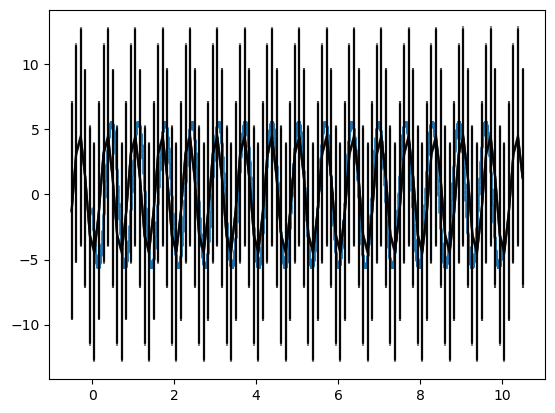

In [27]:
plt.scatter(x_data, y_pure, s=1, alpha=0.5)

xlow, xhigh = plt.xlim()
x = jnp.linspace(xlow, xhigh, 100)

for i in random.choice(rng_key, num_samples, (5,)):
    mu = sine(samples['a'][i],freq,samples['c'][i],x)
    σ = samples['σ_mg'][i]
    plt.errorbar(x, mu, yerr=σ, color='k', alpha=0.5);
    print('a: ',samples['a'][i],'| c: ',samples['c'][i])

print('Actual a: ',my_a,'| Actual c: ',my_c)

obs
a:  4.382454 | c:  4.539306
Actual a:  5.6 | Actual c:  3.3333333333333335


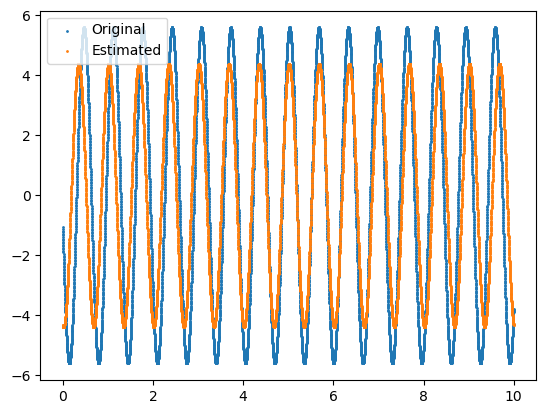

In [28]:
# Bring an angle in radians into the range (0, 2pi)
# This just makes it easier to interpret the c parameter
def convert_angle(angle):
    return angle - 2 * np.pi * floor(angle / (2 * np.pi))

post_pred_samples = infer.Predictive(sine_model, samples)(
    random.PRNGKey(1), x=x_data,
)

for key in post_pred_samples.keys():
    print(key)

post_pred_y = post_pred_samples['obs']

plt.scatter(x_data, y_pure, s=1, alpha=1, label='Original')
line_label = 'posterior predictive model'
scatter_label = 'posterior predictive data'

for i in random.choice(rng_key, len(post_pred_y), (1,)):
    #plt.plot(x_data, post_pred_samples['obs'][i], color='green', alpha=0.5, label=line_label)
    #plt.scatter(x_data, post_pred_y[i], color='k', marker=',', s=0.7, alpha=0.5, label=scatter_label)
    line_label = scatter_label = None
    pred_a = samples['a'][i]
    pred_c = convert_angle(samples['c'][i])
    print('a: ',pred_a,'| c: ',pred_c)
    plt.scatter(x_data, sine(pred_a,freq,pred_c,x_data), label='Estimated', s=1)
    
plt.legend();
print('Actual a: ',my_a,'| Actual c: ',my_c)